In [1]:
import open3d as o3d
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from open3d.visualization import rendering
# Util function for loading point clouds|
from proj_pcd2img import project_3d_to_2d
from segment3dwithAnno import segment3D_with2DAnno, segment3D_With2DMask, create_2d_mask

# Utils for mesh reconstruction
from alphashape import alphashape
import trimesh
import pymeshfix
from copy import deepcopy


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def paint_color(pcd, color:str):
    if color =="red":
        color_code = [1,0,0]
    elif color =="green":
        color_code = [0,1,0]
    elif color =="blue":
        color_code = [0,0,1]
    elif color == "grey":
        color_code = [0.9, 0.9, 0.9]
    else:
        color_code = [0,0,0]
    pcd.paint_uniform_color(np.array(color_code))
    return pcd

def create_two_color_mask(rgb_image):
    """
    Create a binary mask for an RGB image with exactly two colors: black and another uniform color.
    
    Args:
        rgb_image: (H, W, 3) RGB image with only two colors (black + one uniform color).
    
    Returns:
        mask: (H, W) binary mask (True for uniform color, False for black).
    """
    # Find the non-black color (assuming it's uniform)
    non_black_pixels = rgb_image[np.any(rgb_image != [255, 255, 255], axis=-1)]
    if len(non_black_pixels) == 0:
        return np.zeros_like(rgb_image[:, :, 0], dtype=bool)  # All black
    
    # Get the unique non-black color (should be just one)
    uniform_color = non_black_pixels[0]
    
    # Create mask: True where pixel matches the uniform color
    mask = np.all(rgb_image == uniform_color, axis=-1)
    return mask

def o3dpcd2img(pcd, width, height, return_camera=False):
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=width, height=height, visible=False)
    vis.get_render_option().point_size = 2
    vis.add_geometry(pcd)
    view_ctl = vis.get_view_control()
    view_ctl.set_zoom(0.6)
    view_ctl.set_lookat(pcd.get_center())
    view_ctl.set_up((1, 0, 0))  # set the positive direction of the x-axis as the up direction
    view_ctl.set_front((0, 0, 1))  # set the positive direction of the x-axis toward you
    vis.update_renderer()
    img = np.array(vis.capture_screen_float_buffer(True))
    depth = np.array(vis.capture_depth_float_buffer(True))
    mask = create_two_color_mask(img)
    if return_camera:
       # https://www.open3d.org/html/python_api/open3d.camera.PinholeCameraIntrinsic.html
       cam = view_ctl.convert_to_pinhole_camera_parameters()
       return img, depth, mask, cam.intrinsic.intrinsic_matrix, cam.extrinsic
    vis.destroy_window()
    return img, depth, mask



def pcd_2_mesh(pcd):
    alpha = 0.5
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha)
    mesh.compute_vertex_normals()
    return mesh
def rasterize_with_zbuffer(points_3d, H,W):
    """
    Rasterizes 3D points with z-buffering (keeps closest points).
    
    Args:
        points_3d: (N, 3) tensor of 3D points (x, y, z)
        image_size: (height, width) of output image
    
    Returns:
        image: (H, W) binary mask (1 if pixel has a point, else 0)
        depth_buffer: (H, W) depth map (smallest z per pixel)
    """

    device = points_3d.device
    
    # Normalize x, y to [0, 1], keep z for depth
    xy_min = points_3d[:, :2].min(dim=0)[0]
    xy_max = points_3d[:, :2].max(dim=0)[0]
    xy_normalized = (points_3d[:, :2] - xy_min) / (xy_max - xy_min + 1e-6)
    
    # Scale to image dimensions
    u = (xy_normalized[:, 0] * (W - 1)).long()  # [0, W-1]
    v = (xy_normalized[:, 1] * (H - 1)).long()  # [0, H-1]
    z = points_3d[:, 2]  # Depth values
    
    # Initialize buffers
    image = torch.zeros((H, W), device=device)
    depth_buffer = torch.full((H, W), float('inf'), device=device)
    
    # Z-buffering
    for ui, vi, zi in zip(u, v, z):
        if zi < depth_buffer[vi, ui]:
            depth_buffer[vi, ui] = zi
            image[vi, ui] = 1  # Mark occupied pixel
    
    return image, depth_buffer

import torch

def rasterize_with_priority(points_3d, image_size:tuple, axis='xy', highest = True):
    """
    Rasterizes 3D points with priority (highest/lowest first).
    
    Args:
        points_3d: (N, 3) or (B, N, 3) tensor of 3D points.
        image_size: (H, W) output dimensions.
        axis: 
            - 'xy' (top-down view, Z for depth)
            - 'xz' (front view, Y for depth)
            - 'yz' (side view, X for depth)
        priority:
            - 'highest': Points with largest depth are drawn first.
            - 'lowest': Points with smallest depth are drawn first.
    
    Returns:
        image: (H, W) or (B, H, W) binary mask.
        depth_buffer: (H, W) or (B, H, W) depth map.
    """
    H, W = image_size
    device = points_3d.device
    batched = points_3d.dim() == 3
    points_3d[...,2]*=-1
    # Select axes for projection and depth
    if axis == 'xy':
        proj_coords = points_3d[..., :2]  # (N, 2) or (B, N, 2)
        depth = points_3d[..., 2]         # (N,) or (B, N)
    elif axis == 'xz':
        proj_coords = points_3d[..., [0, 2]]
        depth = points_3d[..., 1]
    elif axis == 'yz':
        proj_coords = points_3d[..., [1, 2]]
        depth = points_3d[..., 0]
    else:
        raise ValueError("axis must be 'xy', 'xz', or 'yz'")

    # Normalize projected coordinates to [0, 1]
    proj_min = proj_coords.amin(dim=-2, keepdim=True)  # (1, 2) or (B, 1, 2)
    proj_max = proj_coords.amax(dim=-2, keepdim=True)
    proj_normalized = (proj_coords - proj_min) / (proj_max - proj_min + 1e-6)

    # Scale to image dimensions
    u = (proj_normalized[..., 0] * (W - 1)).long()  # (N,) or (B, N)
    v = (proj_normalized[..., 1] * (H - 1)).long()

    # Sort points by depth (highest or lowest first)
    if highest:
        sort_idx = torch.argsort(depth, descending=True)  # Draw farthest first
    else:
        sort_idx = torch.argsort(depth, descending=False) # Draw closest first

    if batched:
        # Batched sorting (B, N)
        u = torch.gather(u, 1, sort_idx)
        v = torch.gather(v, 1, sort_idx)
        depth = torch.gather(depth, 1, sort_idx)
    else:
        # Single point cloud sorting
        u = u[sort_idx]
        v = v[sort_idx]
        depth = depth[sort_idx]

    # Initialize output
    if batched:
        B = points_3d.shape[0]
        image = torch.zeros((B, H, W), device=device)
        depth_buffer = torch.full((B, H, W), float('inf'), device=device)
    else:
        image = torch.zeros((H, W), device=device)
        depth_buffer = torch.full((H, W), float('inf'), device=device)

    # Rasterize in sorted order
    if batched:
        for b in range(B):
            for ui, vi, zi in zip(u[b], v[b], depth[b]):
                if zi < depth_buffer[b, vi, ui]:  # Overwrite if closer (or farther)
                    depth_buffer[b, vi, ui] = zi
                    image[b, vi, ui] = 1
    else:
        for ui, vi, zi in zip(u, v, depth):
            if zi < depth_buffer[vi, ui]:
                depth_buffer[vi, ui] = zi
                image[vi, ui] = 1

    return image, depth_buffer

In [3]:
pcd = o3d.io.read_point_cloud("multi_tree.ply")
pcd_color = paint_color(pcd, "grey")

width, height = (640, 480)
img, depth, mask_2d = o3dpcd2img(pcd_color, width=width, height=height)
img, depth, mask_2d, intrins, extrinsic = o3dpcd2img(pcd_color, width=width, height=height, return_camera=True)


pcd_selected, mask_2d = segment3D_With2DMask(pcd_color, mask_2d, intrins, extrinsic)



# print(np.array(pcd_selected.points).shape)
# plt.imshow(mask_2d.detach().cpu().numpy())
# plt.show()
# pcd_selected = segment3D_with2DAnno(pcd_color, segment2d_anno, 480, 640, intrins, extrinsic)
# o3d.visualization.draw_geometries([pcd_selected])



are we the same? False
torch.Size([480, 640]) torch.Size([480, 640])


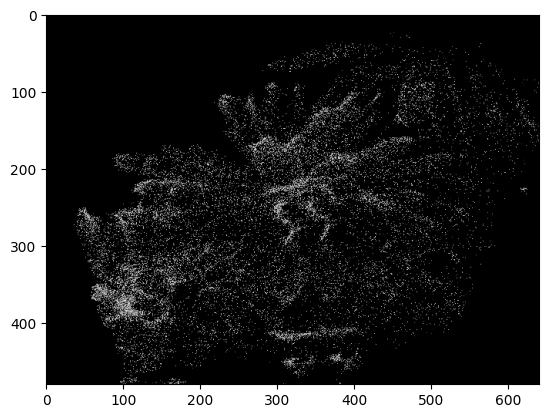

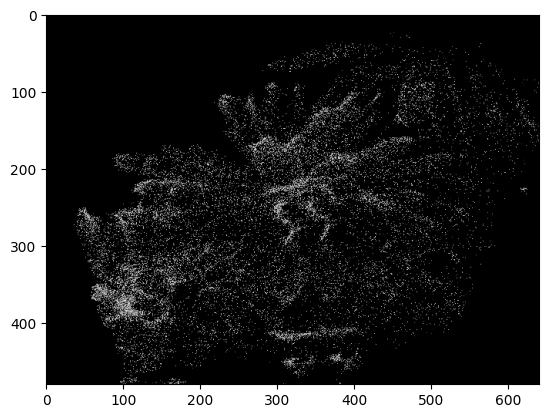

In [ ]:
import numpy as np
import open3d as o3d
from raster_pcd2img import rasterize_3dto2D


# Example usage
if __name__ == "__main__":
    # Generate a sample point cloud (N, 3)
    pointcloud = np.random.rand(1000, 3) * 10
    
    # Create a dummy mask (H, W) (e.g., circle mask)
    H, W = 480, 640
    y, x = np.ogrid[:H, :W]
    center = (W//2, H//2)
    radius = 200
    mask_2d = (x - center[0])**2 + (y - center[1])**2 <= radius**2
    min_pts = np.array(pcd.points).min(axis=0) -1
    max_pts = np.array(pcd.points).max(axis=0) -1
    # Case 1: Highest-first (farthest points prioritized)
    filtered_pc_highest, raster_img, raster_img_filtered = rasterize_3dto2D(
        np.array(pcd.points), 
        mask_2d, 
        #img_shape=(H,W),
        axis='z',
        min_xyz=min_pts,
        max_xyz=max_pts,
        highest_first=False,
        depth_weighting=True
    )
    plt.imshow(raster_img, cmap="gray")
    plt.show()
    plt.imshow(raster_img_filtered*255, cmap="gray")
    plt.show()

    
    
    # Visualize
    pcd_original = o3d.geometry.PointCloud()
    pcd_original.points = o3d.utility.Vector3dVector(pointcloud)
    pcd_original.paint_uniform_color([0.5, 0.5, 0.5])  # Gray
    
    pcd_highest = o3d.geometry.PointCloud()
    pcd_highest.points = o3d.utility.Vector3dVector(filtered_pc_highest)
    pcd_highest.paint_uniform_color([1, 0, 0])  # Red (farthest kept)
    
    
    o3d.visualization.draw_geometries([pcd, pcd_highest])

In [5]:
x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
x_mask = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1], dtype=bool)
x[np.array([4,5])]
x[x_mask]

array([1, 3, 5, 7, 9])

In [6]:
x=0.02
print((1-x)/x)

49.0
